<a href="https://colab.research.google.com/github/imstaHub/hanghae99/blob/master/week3_advanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Week3 Advanced Homework

In [10]:
!pip install tqdm boto3 requests regex sentencepiece sacremoses kagglehub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 79.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 6.4 MB/s eta 0:00:00


In [1]:
import torch

#device setting
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.backends.cuda.is_built():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

cuda


In [2]:
def accuracy(model, dataloader, device):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1)
    #preds = (preds > 0).long()[..., 0]

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

## [My CODE] dataset download

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("debasisdotcom/name-entity-recognition-ner-dataset")

print("Path to dataset files:", path)

100%|██████████| 3.17M/3.17M [00:00<00:00, 172MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/debasisdotcom/name-entity-recognition-ner-dataset/versions/1


In [4]:
import pandas as pd
import os

csv_list = os.listdir(path)
data_list = []
for data_file in csv_list:
    tmp_path = '/'.join([path, data_file])
    print(tmp_path)
    data_list.append(pd.read_csv(tmp_path, encoding='unicode_escape'))

raw_df = pd.concat(data_list)
raw_df.head()

/root/.cache/kagglehub/datasets/debasisdotcom/name-entity-recognition-ner-dataset/versions/1/NER dataset.csv


,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


## [MY CODE] data prerprocessing

문장 개수: 47959
최대 문장 길이: 104


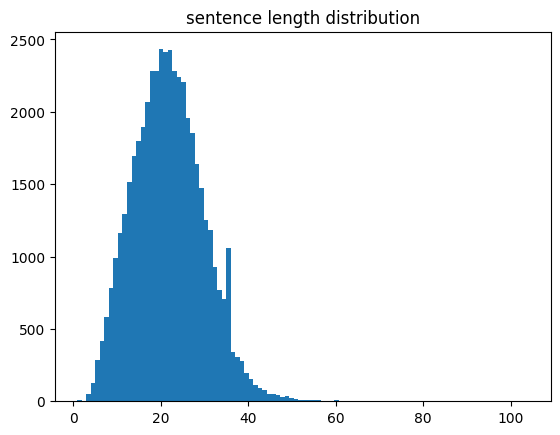

In [5]:
sentence_col='Sentence #'
word_col='Word'
tag_col='Tag'

# fill sentence label
df = raw_df.copy()
df[sentence_col] = df[sentence_col].ffill()

gdf = df.groupby(by=sentence_col)[word_col].count().reset_index()
print('문장 개수:', len(gdf))
print('최대 문장 길이:', gdf[word_col].max())

# 문장 분포
import matplotlib.pyplot as plt

plt.hist(gdf[word_col],bins=100)
plt.title('sentence length distribution')
plt.show()

###########################################
(O 문장) 제거 수: 7042
(O 문장) 제거 대상 예시: ['Sentence: 1000', 'Sentence: 10003', 'Sentence: 10012', 'Sentence: 10015', 'Sentence: 10016', 'Sentence: 1002', 'Sentence: 10020', 'Sentence: 10024', 'Sentence: 10025', 'Sentence: 10030']
###########################################
(nan 포함 문장) 제거 수: 10
(nan 포함 문장) 제거 대상 예시: ['Sentence: 9047', 'Sentence: 11709', 'Sentence: 11759', 'Sentence: 26129', 'Sentence: 28049', 'Sentence: 34152', 'Sentence: 41181', 'Sentence: 41244', 'Sentence: 43177', 'Sentence: 45887']
###########################################
(전처리 후)문장 개수: 40913
(전처리 후)최대 문장 길이: 104


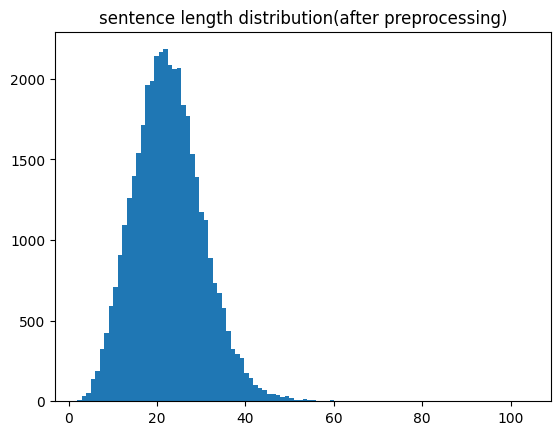

In [6]:
## Tag 중 전부 'O'로 이루어진 문장 삭제
def remove_o_sentence(ser):
    o_all_flag = (ser=='O').all()
    if(o_all_flag): return 'remove'
    else: return ''

gdf = df.groupby(by=sentence_col)[tag_col].apply(remove_o_sentence).reset_index()
remove_sentence = list(gdf.loc[gdf[tag_col]=='remove',sentence_col])
print('###########################################')
print('(O 문장) 제거 수:', len(remove_sentence))
print('(O 문장) 제거 대상 예시:', remove_sentence[:10])

## Word에 NaN이 들어간 문장 삭제
remove_sentence2 = list(df.loc[df[word_col].isna(),sentence_col].unique())
print('###########################################')
print('(nan 포함 문장) 제거 수:', len(remove_sentence2))
print('(nan 포함 문장) 제거 대상 예시:', remove_sentence2)

remove_sentence = list(dict.fromkeys(remove_sentence+remove_sentence2))
df = df[~df[sentence_col].isin(remove_sentence)].reset_index(drop=True)

## data check
gdf = df.groupby(by=sentence_col)[word_col].count().reset_index()
print('###########################################')
print('(전처리 후)문장 개수:', len(gdf))
print('(전처리 후)최대 문장 길이:', gdf[word_col].max())

plt.hist(gdf[word_col],bins=100)
plt.title('sentence length distribution(after preprocessing)')
plt.show()

In [7]:
## label check
tag_list = list(df[tag_col].unique())
print('tag 수:', len(tag_list))
print(tag_list)

tag_info = {}
label_info = {}
for i in range(len(tag_list)):
    tag_info[tag_list[i]] = i
    label_info[i] = tag_list[i]

tag_info

tag 수: 17
['O', 'B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim', 'B-art', 'I-art', 'I-per', 'I-gpe', 'I-tim', 'B-nat', 'B-eve', 'I-eve', 'I-nat']


{'O': 0,
 'B-geo': 1,
 'B-gpe': 2,
 'B-per': 3,
 'I-geo': 4,
 'B-org': 5,
 'I-org': 6,
 'B-tim': 7,
 'B-art': 8,
 'I-art': 9,
 'I-per': 10,
 'I-gpe': 11,
 'I-tim': 12,
 'B-nat': 13,
 'B-eve': 14,
 'I-eve': 15,
 'I-nat': 16}

In [8]:
label_info

{0: 'O',
 1: 'B-geo',
 2: 'B-gpe',
 3: 'B-per',
 4: 'I-geo',
 5: 'B-org',
 6: 'I-org',
 7: 'B-tim',
 8: 'B-art',
 9: 'I-art',
 10: 'I-per',
 11: 'I-gpe',
 12: 'I-tim',
 13: 'B-nat',
 14: 'B-eve',
 15: 'I-eve',
 16: 'I-nat'}

In [11]:
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'distilbert-base-uncased')

df['Token'] = df[word_col].apply(lambda word: tokenizer(word).input_ids[1])
df['Label'] = [tag_info[x] for x in df[tag_col]]

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

## [MY CODE] data를 하나의 row로 변환 및 train, test 분할

In [12]:
df_list = []
for col  in [word_col,'Token','Label']:
    df_list.append(df.groupby(by=[sentence_col])[col].apply(list))

rst_df = pd.concat(df_list, axis=1)
rst_df = rst_df.reset_index()
#rst_df = rst_df.reset_index().rename(columns={'index':'id'})
input_df = rst_df[[word_col,'Token','Label']]
input_df.head()


,Word,Token,Label
0,"[Thousands, of, demonstrators, have, marched, ...","[5190, 1997, 28337, 2031, 9847, 2083, 2414, 20...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, ..."
1,"[Iranian, officials, say, they, expect, to, ge...","[7726, 4584, 2360, 2027, 5987, 2000, 2131, 322...","[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[Helicopter, gunships, Saturday, pounded, mili...","[7739, 4409, 5095, 13750, 16830, 29588, 1999, ...","[0, 0, 7, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 5, ..."
3,"[U.N., relief, coordinator, Jan, Egeland, said...","[1057, 4335, 10669, 5553, 1041, 2056, 4465, 10...","[1, 0, 0, 3, 10, 0, 7, 0, 1, 0, 2, 0, 2, 0, 0,..."
4,"[Mr., Egeland, said, the, latest, figures, sho...","[2720, 1041, 2056, 1996, 6745, 4481, 2265, 101...","[3, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [13]:
from sklearn.model_selection import train_test_split
train_df,test_df = train_test_split(input_df, test_size = 0.2, random_state = 42)

## [MY CODE] Dataset으로 만들기

In [14]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torch.nn.utils.rnn import pad_sequence

# dataframe을 넣어서 torch의 Dataset으로 변경하는 class
class NER_Dataset(Dataset):
    def __init__(self, df):
        self.data = df.to_dict(orient='records')

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]['Word']
        y = self.data[idx]['Label']

        return x, y

# collate 함수에서 label을 input과 shape을 맞추기 위해 직접 pad를 넣는 함수
def pad_labels(labels, max_length):
    padded_labels = [label+[0]*(max_length-len(label)) for label in labels]
    return torch.tensor(padded_labels, dtype=torch.long)

def collate_fn(batch):
    max_len = 104
    texts, labels = [], []
    for row in batch:
        texts.append(row[0])
        labels.append(row[1])

    # 하나의 문장이 아닌 경우, list로 된 문장을 개별로 tokenize. 이후 pad_sequence로 하나의 tensor로 맞춘다
    encodings = [tokenizer(sentence, padding='max_length', truncation=True, max_length=max_len, is_split_into_words=True, return_tensors='pt') for sentence in texts]
    input_ids = [enc.input_ids.squeeze(0) for enc in encodings]
    masks = [enc.attention_mask.squeeze(0) for enc in encodings]

    input_ids = pad_sequence(input_ids, batch_first=True)
    masks = pad_sequence(masks, batch_first=True)

    labels = pad_labels(labels,max_len)

    return input_ids, masks, labels


ds_train = NER_Dataset(df=train_df)
train_loader = DataLoader(
    ds_train, batch_size=64, shuffle=True, collate_fn=collate_fn
)

ds_test = NER_Dataset(df=test_df)
test_loader = DataLoader(
    ds_test, batch_size=64, shuffle=False, collate_fn=collate_fn
)

In [15]:
for data in train_loader:
    inputs, masks, labels = data
    break

inputs

tensor([[  101, 10321,  1998,  ...,     0,     0,     0],
        [  101,  1057,  1012,  ...,     0,     0,     0],
        [  101,  1996,  1057,  ...,     0,     0,     0],
        ...,
        [  101,  1999,  1037,  ...,     0,     0,     0],
        [  101,  1996,  2048,  ...,     0,     0,     0],
        [  101,  1996,  4518,  ...,     0,     0,     0]])

In [16]:
labels

tensor([[5, 0, 5,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 1, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [17]:
print(f'input shape: {inputs.shape} | mask shape" {masks.shape} | label shape: {labels.shape}')

input shape: torch.Size([64, 104]) | mask shape" torch.Size([64, 104]) | label shape: torch.Size([64, 104])


## [LOG] 모델 입력,출력 tensor의 shape 확인

## [MY CODE] Model 정의

In [19]:
model = torch.hub.load('huggingface/pytorch-transformers', 'model', 'distilbert-base-uncased')
model

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main


DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

In [31]:
from torch import nn
from torch.optim import Adam


class NerClassifier(nn.Module):
  def __init__(self, num_labels):
    super().__init__()
    self.num_labels = num_labels

    self.encoder = torch.hub.load('huggingface/pytorch-transformers', 'model', 'distilbert-base-uncased')
    self.classifier = torch.nn.Linear(self.encoder.config.hidden_size, num_labels)

  def forward(self, x, mask):
    x = self.encoder(input_ids=x, attention_mask=mask)['last_hidden_state']
    x = self.classifier(x)

    return x


# 최대 문장 길이
num_labels = len(label_info)
model = NerClassifier(num_labels)

# model freeze
for param in model.encoder.parameters():
  param.requires_grad = False


model = model.to(device)
# loss function 변경, 다중분류
loss_fn = nn.CrossEntropyLoss(ignore_index=0)

lr = 0.001
optimizer = Adam(model.parameters(), lr=lr)

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main


In [32]:
import time

n_epochs = 20

loss_list = []
for epoch in range(n_epochs):
  total_loss = 0.
  model.train()

  start = time.time()
  for data in train_loader:
    model.zero_grad()
    inputs, masks, labels = data
    inputs, masks, labels = inputs.to(device), masks.to(device), labels.to(device).long()

    preds = model(inputs, masks) # batch x embedding_dims x num_labels
    preds = preds.view(-1, preds.shape[-1]) # batch*embedding_dims x num_labels
    labels2 = labels.view(-1) # batch*embedding_dims
    loss = loss_fn(preds, labels2)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  end = time.time() - start
  average_loss = total_loss/len(train_loader)
  loss_list.append(average_loss)
  print(f"Epoch {epoch:3d} | Time : {end} | Train Loss: {total_loss} | Average Train Loss: {average_loss}")


Epoch   0 | Time : 94.21054100990295 | Train Loss: 763.6982562541962 | Average Train Loss: 1.4915981567464769
Epoch   1 | Time : 92.36281037330627 | Train Loss: 673.882936000824 | Average Train Loss: 1.3161776093766093
Epoch   2 | Time : 92.4286470413208 | Train Loss: 653.1827550530434 | Average Train Loss: 1.2757475684629753
Epoch   3 | Time : 92.65267038345337 | Train Loss: 642.3958522677422 | Average Train Loss: 1.254679398960434
Epoch   4 | Time : 92.51661920547485 | Train Loss: 635.6839551925659 | Average Train Loss: 1.2415702249854803
Epoch   5 | Time : 92.49660539627075 | Train Loss: 630.2482444643974 | Average Train Loss: 1.2309536024695262
Epoch   6 | Time : 92.72688961029053 | Train Loss: 627.8048744797707 | Average Train Loss: 1.226181395468302
Epoch   7 | Time : 92.36959147453308 | Train Loss: 624.9503229856491 | Average Train Loss: 1.220606099581346
Epoch   8 | Time : 92.75778150558472 | Train Loss: 623.206182539463 | Average Train Loss: 1.2171995752723888
Epoch   9 | Time

## [LOG] 학습결과: loss가 조금씩 내려가고 있다.

In [ ]:
# 기존 accuracy 코드
# with torch.no_grad():
#   model.eval()
#   train_acc = accuracy(model, train_loader, device)
#   test_acc = accuracy(model, test_loader, device)
#   print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")

## [FEEDBACK] accuracy를 어떻게 비교해야 할 지 모르겠습니다.